In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
print('Setup done')

Setup done


In [2]:
# from google.colab import drive

# drive.mount('/content/gdrive',force_remount=True)

### Reading csv

In [4]:
df = pd.read_csv('./dataset/dataset_brazil.csv')
df['Date']= pd.to_datetime(df['Date'])

df_client_rfm = pd.read_csv('./dataset/client_rfm.csv', sep=',')

print("dataset Loaded")

dataset Loaded


In [5]:
df_client_rfm = df_client_rfm[['Client','Rank_Recency','Rank_Frequency','Rank_Monetary','Cluster']]

In [6]:
df.tail()

,Unnamed: 0,Company Code,Order Number,Product,Product Category,Client,Client City,Product Cost,Discount Amount,Amount,Total,Form of payment,Date,ProductId,Rating
1628920,1628920,10743000,1526356,Gasoline,Fuel,Angelo Wagner,Clinas,3.657,0.0,37.985,150.00,Extended payment plan/ In installments,2019-03-16 08:16:00,354807203625,5.0
1628921,1628921,39000,8497,Diesel Auto Clean,Fuel,Felix Daniels,Wadena,2.453,0.0,53.981,154.87,Credit Card,2017-04-03 07:50:00,3569202421,3.5
1628922,1628922,122000,1283003,Special Gasoline,Fuel,Karl Bridges,Chico,3.493,0.0,26.000,114.37,Extended payment plan/ In installments,2018-12-01 15:49:00,26945203461,7.5
1628923,1628923,122000,1283023,Special Gasoline,Fuel,Karl Bridges,Chico,3.493,0.0,26.000,114.37,Extended payment plan/ In installments,2018-12-01 16:11:00,26945203461,7.5
1628924,1628924,122000,1283030,Special Gasoline,Fuel,Karl Bridges,Chico,3.493,0.0,26.000,114.37,Extended payment plan/ In installments,2018-12-01 16:21:00,26945203461,7.5


In [8]:
df_client_product = df[['Client','ProductId','Rating']].copy()
df_client_product = pd.merge(df_client_product,df_client_rfm,on='Client',how='left')

df_client_product.drop_duplicates(keep='first',inplace=True,subset=['Client','ProductId']) 


n_users = df_client_product['Client'].nunique()
n_users

10816

In [9]:
df_product = df[['ProductId','Product','Product Category','Product Cost']].copy()
df_product.drop_duplicates(keep='first',inplace=True) 

n_prod = df_product['ProductId'].nunique()
n_prod

54708

#### Enocding prod-ID

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

prod_enc = LabelEncoder()
df_client_product['Client'] = prod_enc.fit_transform(df_client_product['Client'].values)

# prod_enc = LabelEncoder()
# df_product['Product'] = prod_enc.fit_transform(df_product['Product'].values)

# prod_cat_enc = LabelEncoder()
# df_product['Product Category'] = prod_cat_enc.fit_transform(df_product['Product Category'].values)

prod_id_enc = LabelEncoder()
df_product['ProductId'] = prod_id_enc.fit_transform(df_product['ProductId'].values)
df_client_product['ProductId'] = prod_id_enc.transform(df_client_product['ProductId'].values)

### save product csv for flask

In [11]:
train, test = train_test_split(df_client_product, test_size=0.2, random_state=42)

In [12]:
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-2,
    decay_steps=10000,
    decay_rate=0.9)
opt = keras.optimizers.Adam(learning_rate=lr_schedule)

from keras.layers import Input, Embedding, Flatten, Dot, Dense,Concatenate
from keras.models import Model
from keras.optimizers import SGD


In [13]:
# model 1 ids
def create_model():
    product_input = Input(shape=[1], name="Product-Input")

    product_embedding = Embedding(n_prod+1, 5, name="Product-Embedding")(product_input)
    product_vec = Flatten(name="Flatten-Product")(product_embedding)

    user_input = Input(shape=[1], name="User-Input")
    user_embedding = Embedding(n_users+1, 5, name="User-Embedding")(user_input)
    user_vec = Flatten(name="Flatten-Users")(user_embedding)
    prod = Dot(name="Dot-Product", axes=1)([product_vec, user_vec])
    model = Model([user_input, product_input], prod)
    model.compile( loss='mean_squared_error',optimizer=opt)
    return model


In [14]:
model = create_model()
history = model.fit([train[['Client']],
                     train[['ProductId']]], train['Rating'],
                    validation_data=
                    ([test[['Client']],
                      test['ProductId']], test['Rating']), epochs=5, verbose=1)

# model.save('regression_model_basic.h5')

Epoch 1/5
12577/12577 [==============================] - 45s 3ms/step - loss: 17.0612 - val_loss: 3.5951
Epoch 2/5
12577/12577 [==============================] - 41s 3ms/step - loss: 2.1205 - val_loss: 2.3931
Epoch 3/5
12577/12577 [==============================] - 41s 3ms/step - loss: 1.1086 - val_loss: 2.0276
Epoch 4/5
12577/12577 [==============================] - 41s 3ms/step - loss: 0.7860 - val_loss: 1.8120
Epoch 5/5
12577/12577 [==============================] - 42s 3ms/step - loss: 0.6137 - val_loss: 1.6699


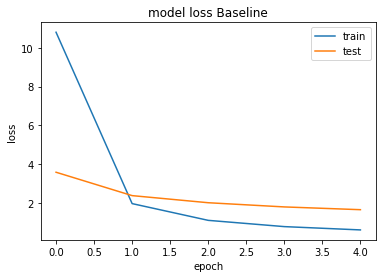

In [15]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("model loss Baseline")

plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper right")
plt.show()


In [16]:
test[['Client','Rank_Recency','Rank_Frequency','Rank_Monetary','Cluster']].iloc[1]
test['ProductId'].values
product_db = np.array(list(set(test['ProductId'])))

In [22]:
# Creating dataset for making recommendations for the first user
# Without RFM

product_db = np.array(list(set(train['ProductId'])))

user = test[['Client','Rank_Recency','Rank_Frequency','Rank_Monetary','Cluster']].iloc[1]
user = np.array([1 for i in range(len(product_db))])

predictions = model.predict([user, product_db])

predictions = np.array([a[0] for a in predictions])

# recommended_book_ids = (-predictions).argsort()[:5]
# print(recommended_book_ids)
# print(predictions[recommended_book_ids])

In [23]:
predictions

array([-0.05453861,  2.0040338 ,  0.13480043, ..., -1.2541056 ,
        2.7739727 ,  2.234133  ], dtype=float32)

In [24]:
max(predictions)

7.5846205